In [1]:
from collections import namedtuple
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import os

# Analysis Raw Data

In [2]:
def analyze_raw_data():
    raw_data = pd.DataFrame(columns=["dir_name", "subdir_num", "table_num"])
    all_id_dir = [ i for i in glob.iglob("Data/*") ]
    Item = namedtuple("Item", "dir_name, subdir_num, table_num")
    for id_dir in all_id_dir:
        sub_dir = [ i for i in glob.iglob("%s/*"     % id_dir ) if os.path.isdir(i)    ]
        table   = [ i for i in glob.iglob("%s/*"     % id_dir ) if not os.path.isdir(i)]

        data = Item(id_dir, len(sub_dir), len(table))
        data = data._asdict()
        raw_data = raw_data.append(data, ignore_index=True)
    return raw_data

def check_id_consistence():
    all_id_dir = [ i for i in glob.iglob("Data/*") ]
    for id_dir in all_id_dir:
        sub_dir = [ i for i in glob.iglob("%s/*"     % id_dir ) if os.path.isdir(i)    ]
        table   = [ i for i in glob.iglob("%s/*"     % id_dir ) if not os.path.isdir(i)]
        if len(sub_dir) == 1 and len(table) == 1:
            sub_dir_name = sub_dir[0][sub_dir[0].rfind("\\")+1:]
            table_name = table[0][table[0].rfind("\\")+1:]

            id_dir_name = id_dir[id_dir.rfind("\\")+1:]
            sub_dir_name = sub_dir_name.split(" ")[0]
            table_name   = table_name.split(" ")[0]

            if not id_dir_name == sub_dir_name == table_name:
                print(id_dir_name, sub_dir_name, table_name)

In [3]:
raw_data_table = analyze_raw_data()

equal_data = raw_data_table[(raw_data_table["subdir_num"] == 1) & (raw_data_table["table_num"] == 1) ]
noneq_data = raw_data_table[(raw_data_table["subdir_num"] != 1) | (raw_data_table["table_num"] != 1) ]
noneq_data[(noneq_data["table_num"] == 0) ].reset_index()

,index,dir_name,subdir_num,table_num
0,58,Data\034852,1,0
1,72,Data\043521_1,1,0
2,97,Data\064768_2,1,0
3,118,Data\111084_1,1,0
4,127,Data\415134_2,1,0
5,140,Data\421730,1,0
6,153,Data\430348,1,0
7,169,Data\602260_1,1,0
8,170,Data\602260_2,1,0
9,173,Data\627337,1,0


整理過後發現，共 26 個資料夾沒有表格照片，可能需要請他們補上或是對於如果有需要表格照片時就不要用這些資料夾
不過對於其他問題，可以把他們留下來

# Resolution Analysis

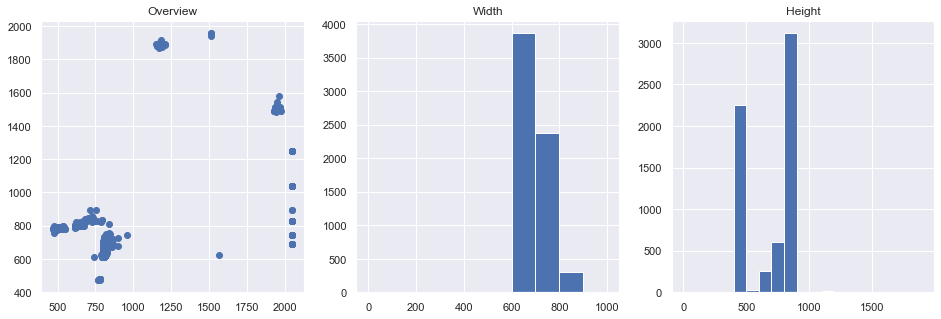

In [4]:
def plot_resolution():
    all_shape  = [ Image.open(i).size for i in glob.iglob("Data/*/*/*") ]
    all_width  = [ shape[1] for shape in all_shape ]
    all_height = [ shape[0] for shape in all_shape ] 

    sns.set()
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 3, 1)
    plt.title("Overview")
    for (x, y) in all_shape:
        plt.plot(x, y, "ob")

    plt.subplot(1, 3, 2)
    plt.title("Width")
    plt.hist(all_width, bins=np.arange(0, 1100, 100))

    plt.subplot(1, 3, 3)
    plt.title("Height")
    plt.hist(all_height, bins=np.arange(0, 2000, 100))

    plt.show()
plot_resolution()

In [5]:
def resolution_analyze():
    resolution = pd.DataFrame(columns=["dir_name", "table_resolution"])
    all_id_dir = [ i for i in glob.iglob("Data/*") ]
    Item = namedtuple("Item", "dir_name, table_resolution, width_upper, height_upper")
    for id_dir in all_id_dir:

        table   = [ i for i in glob.iglob("%s/*"     % id_dir ) if not os.path.isdir(i)]
        if not table:
            continue

        images  = [ Image.open(i).size for i in glob.iglob("%s/*/*"     % id_dir)  ]

        bins = np.arange(0, 3000, 100)
        digitized = np.digitize(images, bins)

        unique_w, counts_w = np.unique(digitized[:, 0], return_counts=True)
        unique_h, counts_h = np.unique(digitized[:, 1], return_counts=True)

        h_freq = np.asarray((unique_h, counts_h)).T
        w_freq = np.asarray((unique_w, counts_w)).T

        sort_h_freq = h_freq[np.argsort(h_freq[:,1])]
        sort_w_freq = w_freq[np.argsort(w_freq[:,1])]

        w_upper = max(sort_h_freq[-2:, 0])* 100
        h_upper = max(sort_w_freq[-2:, 0])* 100


        data = Item(id_dir, Image.open(table[0]).size, w_upper, h_upper)
        data = data._asdict()
        resolution = resolution.append(data, ignore_index=True)
    return resolution

In [6]:
resolution = resolution_analyze()
resolution[ (resolution["height_upper"] > 900) | (resolution["width_upper"] > 1000) ]

,dir_name,table_resolution,height_upper,width_upper
9,Data\004359,"(933, 626)",2000.0,1900.0
291,Data\S114283,"(1788, 904)",2000.0,800.0


由此可知, 有兩個資料夾的照片解析度太高，因此可能需要多加考量

In [17]:
raw_data_table = analyze_raw_data()
resolution = resolution_analyze()

merged_inner = pd.merge(left=raw_data_table, right=resolution, left_on='dir_name', right_on='dir_name')
merged_inner

,dir_name,subdir_num,table_num,table_resolution,height_upper,width_upper
0,Data\000408,1,1,"(1708, 807)",900.0,800.0
1,Data\000411,1,1,"(1743, 803)",900.0,800.0
2,Data\001742,1,1,"(1738, 729)",800.0,800.0
3,Data\002456,1,1,"(1735, 728)",900.0,800.0
4,Data\002555,1,1,"(1501, 723)",900.0,800.0
...,...,...,...,...,...,...
299,Data\S469585_1,1,1,"(1788, 904)",900.0,800.0
300,Data\S469585_2,1,1,"(1788, 904)",900.0,800.0
301,Data\S594966_1,1,1,"(1788, 904)",800.0,800.0
302,Data\S594966_2,1,1,"(1788, 904)",900.0,800.0


In [19]:
merged_inner[ (merged_inner["subdir_num"] == 1) & (merged_inner["table_num"] == 1) & (merged_inner["height_upper"] <= 900) & (merged_inner["width_upper"] <= 1000)]

,dir_name,subdir_num,table_num,table_resolution,height_upper,width_upper
0,Data\000408,1,1,"(1708, 807)",900.0,800.0
1,Data\000411,1,1,"(1743, 803)",900.0,800.0
2,Data\001742,1,1,"(1738, 729)",800.0,800.0
3,Data\002456,1,1,"(1735, 728)",900.0,800.0
4,Data\002555,1,1,"(1501, 723)",900.0,800.0
...,...,...,...,...,...,...
299,Data\S469585_1,1,1,"(1788, 904)",900.0,800.0
300,Data\S469585_2,1,1,"(1788, 904)",900.0,800.0
301,Data\S594966_1,1,1,"(1788, 904)",800.0,800.0
302,Data\S594966_2,1,1,"(1788, 904)",900.0,800.0


In [20]:
raw_data_table

,dir_name,subdir_num,table_num
0,Data\000408,1,1
1,Data\000411,1,1
2,Data\001742,1,1
3,Data\002456,1,1
4,Data\002555,1,1
...,...,...,...
325,Data\S469585_1,1,1
326,Data\S469585_2,1,1
327,Data\S594966_1,1,1
328,Data\S594966_2,1,1


### 如果扣掉 JPG 只有 299張表格, ,記得記錄在表格中extension